In [1]:
import torch
from model import DenseDepth

In [55]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
model = DenseDepth()

In [157]:
model.load_state_dict(torch.load('model_saved/epoch_5'))

<All keys matched successfully>

In [158]:
file_list = glob.glob('example_neurodigm_*.jpg')
example_list = list()
for path in file_list:
    inputs = np.asarray(Image.open(path).resize((640, 360)))
    example_list.append(inputs[None, ...])
#     plt.imshow(inputs)
#     plt.show()

inputs_batch = np.concatenate(example_list, axis=0).transpose(0, 3, 1, 2)
inputs_tensor = torch.tensor(inputs_batch).float()
depth_map = model(inputs_tensor)

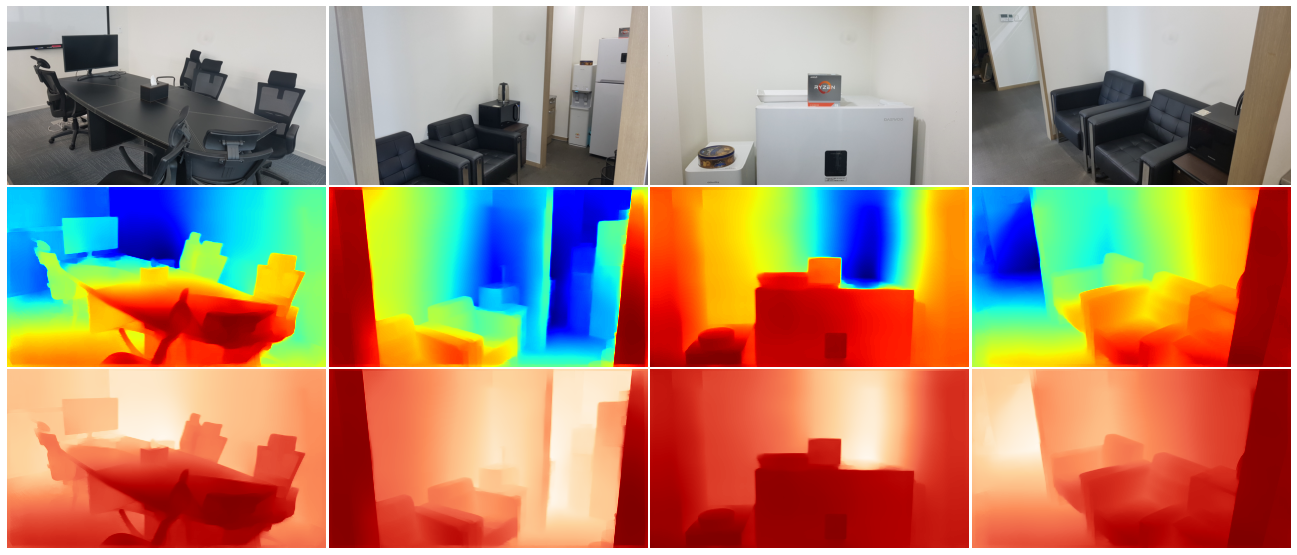

In [159]:
plt.figure(figsize=(23, 10))
num_sample = len(file_list)
for i, result in enumerate(depth_map):
    depth = result.detach().numpy()[0]
    plt.subplot(3, num_sample, i+1)
    plt.axis('off')
    plt.imshow(example_list[i][0])
    plt.subplot(3, num_sample, i+1+num_sample)
    plt.axis('off')
    plt.imshow(depth, cmap='jet')
    plt.subplot(3, num_sample, i+1+num_sample*2)
    plt.axis('off')
    plt.imshow(depth, cmap='OrRd')
plt.subplots_adjust(wspace=0.01, hspace=0)
plt.show()

In [81]:
import torch.nn as nn
import torch.nn.functional as F

In [121]:
class SSIM(nn.Module):
    """Calculate the structure similarity."""
    def __init__(self, dynamic_range=9.6, exponents=(1, 1, 1), sigma=1.5, window_size=11):
        super().__init__()
        self.C1 = (.01 * dynamic_range) ** 2
        self.C2 = (.03 * dynamic_range) ** 2
        self.C3 = self.C2 / 2

        self.window_size = window_size
        self.exponents = exponents
        self.gaussian_kernel = torch.tensor(self.make_gaussian_filter(window_size, sigma), dtype=torch.float)

    def forward(self, pred, target):
        mu_kernel = self.gaussian_kernel.to(pred.device)

        mu_pred = F.conv2d(pred, mu_kernel)
        mu_target = F.conv2d(target, mu_kernel)
        var_pred = F.conv2d(pred.square(), mu_kernel) - mu_pred.square()
        var_target = F.conv2d(target.square(), mu_kernel) - mu_target.square()
        cov_pred_target = F.conv2d(target * pred, mu_kernel) - mu_target * mu_pred

        l = (2 * mu_pred * mu_target + self.C1) / (mu_pred.square() + mu_target.square() + self.C1)
        c = (2 * var_pred.sqrt() * var_target.sqrt() + self.C2) / (var_pred + var_target + self.C2)
        s = (cov_pred_target + self.C3) / (var_pred.sqrt() * var_target.sqrt() + self.C3)

        alpha, beta, gamma = self.exponents
        ssim = l.pow(alpha) * c.pow(beta) * s.pow(gamma)

        return ssim.mean(), l, c, s, ssim

    @staticmethod
    def make_gaussian_filter(window_size, sigma):
        assert (window_size >= 3) and (window_size % 2 == 1)
        k = (window_size-1)//2
        probs = [np.exp(-z * z / (2 * (sigma ** 2))) / np.sqrt(2 * np.pi * (sigma ** 2)) for z in range(-k, k + 1)]
        kernel = np.outer(probs, probs).reshape(1, 1, window_size, window_size)
        return kernel

In [122]:
ssim = SSIM()

In [123]:
origin = torch.tensor(np.asarray(Image.open('example_neurodigm_0.jpg').resize((640, 360)).convert('L'))[None, None, ...]).float()
blur = torch.tensor(np.asarray(Image.open('example_neurodigm_0.jpg').resize((320, 180)).resize((640, 360)).convert('L'))[None, None, ...]).float()
with torch.no_grad():
    _, l_b, c_b, s_b, ss_b = ssim(blur, origin)

In [125]:
l_b.detach_().squeeze_()
c_b.detach_().squeeze_()
s_b.detach_().squeeze_()
ss_b.detach_().squeeze_()

tensor([[0.9482, 0.9115, 0.8701,  ..., 0.9181, 0.9306, 0.9435],
        [0.9477, 0.9083, 0.8597,  ..., 0.9192, 0.9305, 0.9449],
        [0.9428, 0.9054, 0.8580,  ..., 0.9269, 0.9338, 0.9431],
        ...,
        [0.9672, 0.9756, 0.9772,  ..., 0.9319, 0.9640, 0.9736],
        [0.9619, 0.9720, 0.9772,  ..., 0.9187, 0.9572, 0.9688],
        [0.9573, 0.9694, 0.9758,  ..., 0.9066, 0.9499, 0.9630]])

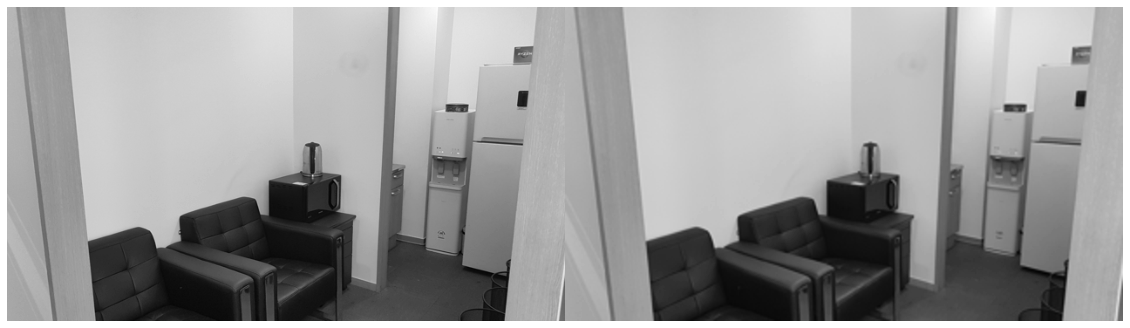

In [131]:
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(np.squeeze(np.concatenate([origin.detach().numpy(), blur.detach().numpy()], axis=-1)), cmap='gray')

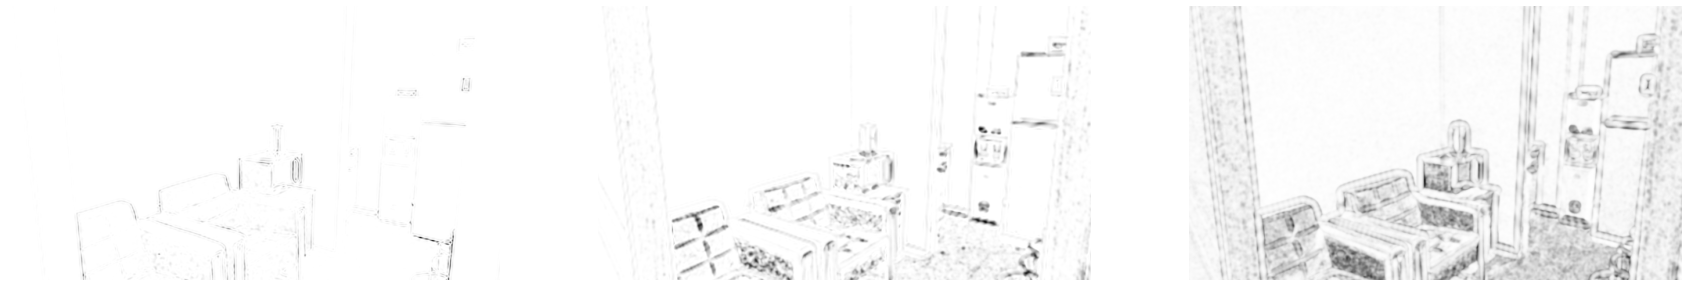

In [135]:

plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(l_b, cmap='gray')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(c_b, cmap='gray')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(s_b, cmap='gray')

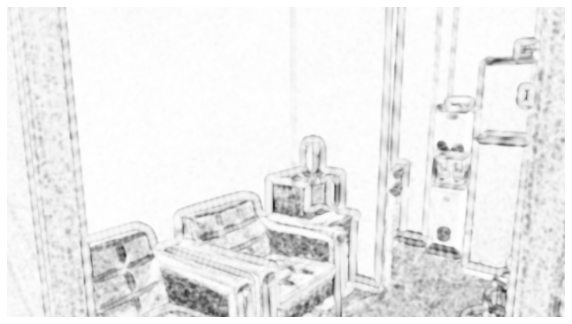

In [136]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(ss_b, cmap='gray')